In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd

# sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
sys.path.insert(1, "/oak/stanford/groups/paragm/gautam/prospection/K2/src")
from utils import deserialize, serialize, deserialize_model

In [3]:
import pandas as pd
# dfGs_all = pd.read_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.csv")
dfGs_all = pd.read_csv("/oak/stanford/groups/paragm/hazy_backup/data_envs/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.csv")

## construct a dataset

In [4]:
def parse_df_list(row):
    row = row.split(" ")
    row = [r.strip() for r in row]
    row = [r.rstrip("]") for r in row]
    row = [r.lstrip("[]") for r in row]
    row = [float(r) for r in row if r not in ["[", "", "]"]]     
    return row

In [5]:
df_0 = dfGs_all[dfGs_all["class_member"] == 0]
# df_0 = dfGs_all[dfGs_all["salbin"] == "non-salient"]
df_1sal = dfGs_all[dfGs_all["salbin"] == "salient"]
# df_filtered = pd.concat([df_0, df_1sal])
# df_filtered = df_filtered.sample(frac=1)

In [6]:
df_1sal.shape, df_0.shape

((164499, 11), (762207, 11))

In [7]:
n = df_1sal.shape[0]
n

164499

In [8]:
df_sample0 = df_0.sample(n=n, replace=False, random_state=1)
df_sample1 = df_1sal.sample(n=n, replace=False, random_state=1)

In [9]:
# df_filtered = pd.concat([df_0, df_1sal])
df_filtered = pd.concat([df_sample0, df_sample1])
df_filtered = df_filtered.sample(frac=1)
df_filtered.shape

(328998, 11)

## get train test split

In [10]:
# df_test = pd.concat([df_sample0, df_sample1])
# df_test = df_filtered.sample(frac=0.2, random_state=1)


In [11]:
# df_test.shape

In [12]:
df_filtered.shape

(328998, 11)

In [13]:
X = df_filtered.loc[:, "raw"]
X = X.apply(lambda x: parse_df_list(x))
X_raw = np.vstack(list(X.values))

In [14]:
# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p, validate=True)
# X = transformer.transform(X)

In [15]:
y_base = list(df_filtered.loc[:, "salient"].values)
print(y_base[0:20])
y_raw = np.array([0 if np.isnan(i) else 1 for i in y_base])
print(y_raw[0:20])

[np.float64(2.0), np.float64(nan), np.float64(0.0), np.float64(nan), np.float64(4.0), np.float64(0.0), np.float64(nan), np.float64(nan), np.float64(2.0), np.float64(nan), np.float64(5.0), np.float64(0.0), np.float64(2.0), np.float64(nan), np.float64(5.0), np.float64(nan), np.float64(0.0), np.float64(nan), np.float64(nan), np.float64(nan)]
[1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import utils

X, Xt, y, yt = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42) 

scaler = MinMaxScaler()
scaler.fit(X)
# utils.serialize(scaler, "/oak/stanford/groups/paragm/gautam/prospection/K2/notebooks/spatial-bio/scaler_6-26.obj")

X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [17]:
print(X.shape, y.shape)
print(Xt.shape, yt.shape)

(263198, 34) (263198,)
(65800, 34) (65800,)


In [18]:
type(y)

numpy.ndarray

In [19]:
y_scramble = np.random.permutation(y) # used for baselines

In [20]:
print("class-1:",np.sum(y), np.sum(y) / y.shape[0])
print("class-0:",(y.shape[0] - np.sum(y)), (y.shape[0] - np.sum(y)) / y.shape[0])

class-1: 131445 0.49941488917089033
class-0: 131753 0.5005851108291096


In [21]:
# df_test = df_test.sample(frac=1)

# Xt = df_test.loc[:, "raw"]
# Xt = Xt.apply(lambda x: parse_df_list(x))
# Xt = np.vstack(list(Xt.values))

In [22]:
Xt.shape

(65800, 34)

In [23]:
# Xt = transformer.transform(Xt)
# Xt = scaler.transform(Xt)

In [24]:
# yt = list(df_test.loc[:, "salient"].values)
# print(yt[0:20])
# yt = np.array([0 if np.isnan(i) else 1 for i in yt])
# print(yt[0:20])

In [25]:
np.sum(yt), len(yt)

(np.int64(33054), 65800)

In [26]:
# G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
G_ex = deserialize("/oak/stanford/groups/paragm/hazy_backup/data_envs/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [27]:
# idxs = [all_feats.index(i) for i in ['BETA_TUBULIN', "CK5", 'CK7', 'P4EBP1', 'PANKERATIN', 'PHOSPHOTYROSINE']]
# idxs

In [28]:
from feature_selection import top_positives_threshold_mass

## Logistic Regression

We can prune X to only important features

In [28]:
# Xp = X[:, idxs]
# Xp.shape

In [29]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2', solver="saga", random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf_all = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# clf = LogisticRegression(solver='newton-cholesky', random_state=1, max_iter=10000)
# clf.fit(X,y)
clf_all.fit(X,y)

LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   random_state=6, solver='saga', tol=1e-06)

In [30]:
clf_all.score(X, y)

0.7135388566782422

- right before: 0.7140897727186377
, 0.7145647003396682, 0.7147622702300169

In [31]:
clf_all.score(Xt, yt)

0.7159726443768997

- right before: 0.7141489361702128
, 0.7130547112462006, 0.7120364741641337

In [32]:
b = np.array(clf_all.coef_[0]) # importance weights
print(b)

[-3.8333447  -2.24182401 -1.11434091 -0.67025574  3.15743922 -0.76362177
  0.82016415 -1.92454821 -1.76627629  1.79373692  5.08450267 -1.04388857
 15.89751974 -9.25692537  2.80137394 -4.77625281  0.02303988 -0.72275199
  1.55189741 -3.67587471 -1.26322557  2.36884769 -0.98297611 -2.5513787
  0.62771477  2.36578983 -3.89484117  4.08562797 -5.36110898  1.25946546
 -0.10572351  4.61436195  0.80791176 -4.10548893]


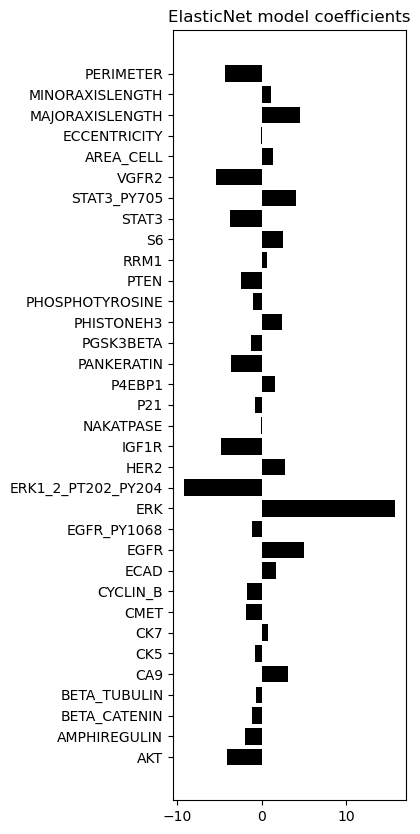

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

b = np.array(clf_all.coef_[0]) # importance weights
plt.barh(all_feats, b, color="k")


# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

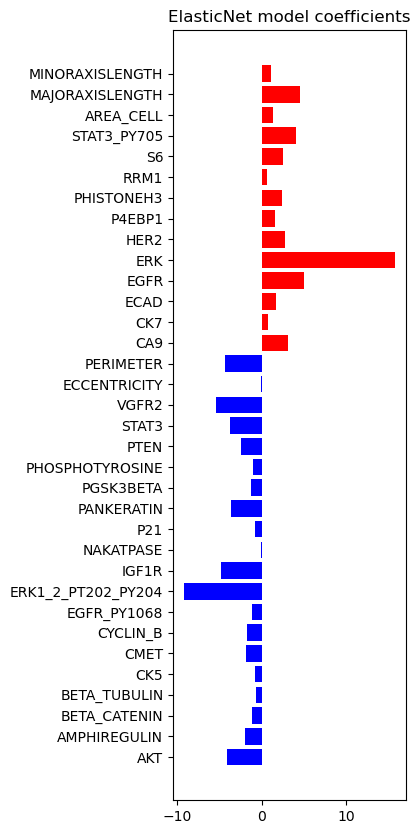

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))
mask0 = b <= 0
mask1 = b > 0
feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

plt.barh(feats0, b[mask0], color='blue')
plt.barh(feats1, b[mask1], color='red')

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [35]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ERK', np.float64(15.734112543688681)),
 ('EGFR', np.float64(5.037200656365817)),
 ('MAJORAXISLENGTH', np.float64(4.561092057918314)),
 ('STAT3_PY705', np.float64(4.010167940027546)),
 ('CA9', np.float64(3.1141389333790195))]

### Feature cutoffs

In [35]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

NameError: name 'scores' is not defined

In [39]:
from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y, clf.predict_proba(X)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(yt, clf_all.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

np.float64(0.7828918631596871)

previous: 0.779946752083371

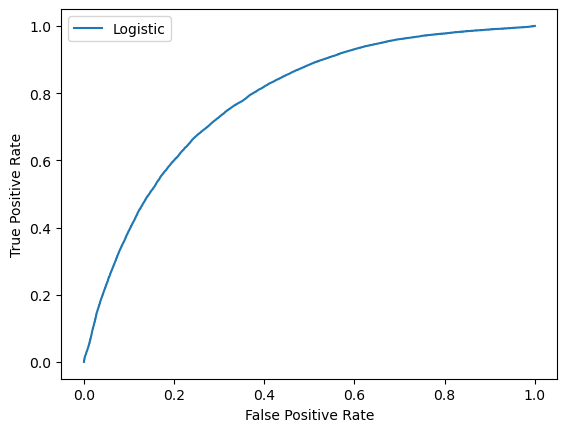

In [40]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [41]:
metrics.balanced_accuracy_score(yt, clf_all.predict(Xt))

np.float64(0.714152343139022)

previous: 0.7131141323225845

In [42]:
metrics.balanced_accuracy_score(yt, clf_all.predict(Xt), adjusted=True)

np.float64(0.42830468627804397)

previous: 0.42622826464516894

In [191]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X, y, cv=5)
# print(scores)

In [41]:
clf_all_scrambled = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf_all_scrambled.fit(X, y_scramble)

LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   random_state=6, solver='saga', tol=1e-06)

## One-vs-rest Classification

In [29]:
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

In [30]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

Let's up the number of train split examples so the model can properly learn the important features of each salient group

In [31]:
# y_multi = list(df_filtered.loc[:, "salient"].values)
# print(y_multi[0:20])
# y_multi = np.array([0 if np.isnan(i) else int(i) for i in y_multi])
y_multi = np.array([-1 if np.isnan(i) else int(i) for i in y_base])
print(y_multi[0:20])

[-1 -1 -1 -1 -1 -1 -1  2  5 -1  0 -1  7 -1 -1  9 -1  2  4  0]


In [32]:
X, Xt, y_multi, yt_multi = train_test_split(X_raw, y_multi, test_size=0.1, random_state=42) 

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [33]:
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# clf = OneVsRestClassifier(clf).fit(X, y_multi)

In [34]:
# clf.score(X, y_multi)

- right before: 0.6183966119325358
- used to have score of 0.5925938318365744, 0.5385387528942543

In [35]:
# yt_multi = list(df_test.loc[:, "salient"].values)
# print(yt[0:20])
# yt_multi = np.array([-1 if np.isnan(i) else int(i) for i in yt_multi])
# print(yt_multi[0:20])

In [36]:
# clf.score(Xt, yt_multi)

- right before: 0.6175379939209726

In [37]:
# clf.estimators_

In [38]:
# clf.classes_

### Jump here if want to analyze weights only

In [39]:
import utils
# utils.serialize(clf, "/scr/gmachi/prospection/K2/notebooks/spatial-bio/elasticnet_model_2-13.obj")
clf = utils.deserialize("/oak/stanford/groups/paragm/gautam/prospection/K2/notebooks/spatial-bio/elasticnet_model_2-13.obj")


/oak/stanford/groups/paragm/gautam/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/oak/stanford/groups/paragm/gautam/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/oak/stanford/groups/paragm/gautam/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpick

In [40]:
from feature_selection import compute_aic, compute_aic_ovr

In [41]:
aic_by_class = compute_aic_ovr(clf, X, y_multi)
print("AIC per class (with all features):")
for cls, aic in aic_by_class.items():
    print(f"Class {cls}: AIC = {aic:.2f}")

AIC per class (with all features):
Class -1: AIC = 338311.43
Class 0: AIC = 118375.13
Class 1: AIC = 78097.52
Class 2: AIC = 95149.18
Class 3: AIC = 18075.35
Class 4: AIC = 95989.37
Class 5: AIC = 104987.52
Class 6: AIC = 19722.12
Class 7: AIC = 105338.97
Class 8: AIC = 366.31
Class 9: AIC = 51409.67
Class 10: AIC = 9672.24
Class 11: AIC = 25246.44


In [42]:
from feature_selection import compute_aic_by_threshold, plot_aic_k_threshold, plot_aic_threshold_k, plot_max_aic_per_k, plot_max_aic_per_k_rescaled

In [43]:
from feature_selection import find_importance_threshold, analyze_feature_importance, find_elbow, analyze_feature_importance_positives 

In [44]:
from feature_selection import aggregate_max_aic_per_k

In [45]:
# G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
G_ex = deserialize("/oak/stanford/groups/paragm/hazy_backup/data_envs/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [46]:
from feature_selection import run_full_aic_analysis

### Concept 0

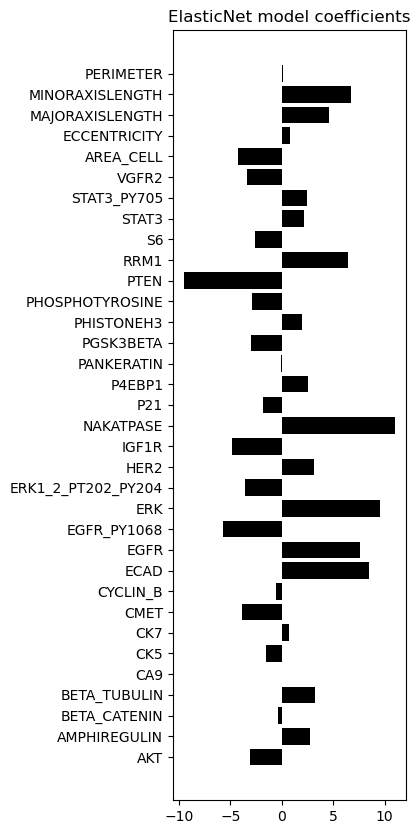


positive weights:
[('NAKATPASE', np.float64(11.002236950058245)), ('ERK', np.float64(9.571100425046513)), ('ECAD', np.float64(8.425057124558052)), ('EGFR', np.float64(7.609956362515509)), ('MINORAXISLENGTH', np.float64(6.757945447949965))]
[(np.str_('NAKATPASE'), np.float64(11.002236950058245)), (np.str_('ERK'), np.float64(9.571100425046513)), (np.str_('ECAD'), np.float64(8.425057124558052)), (np.str_('EGFR'), np.float64(7.609956362515509)), (np.str_('MINORAXISLENGTH'), np.float64(6.757945447949965)), (np.str_('RRM1'), np.float64(6.393502161537415)), (np.str_('MAJORAXISLENGTH'), np.float64(4.5729348129750464))]

visualizing positive weights:


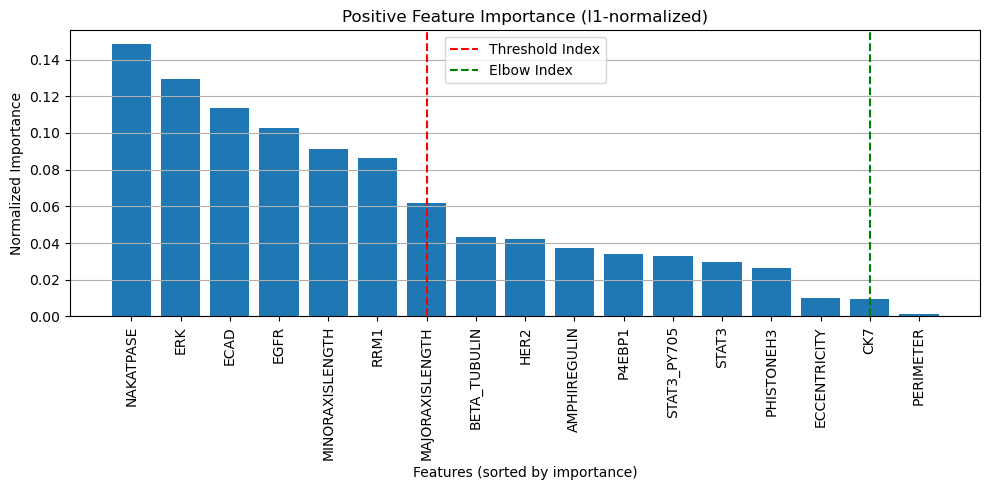

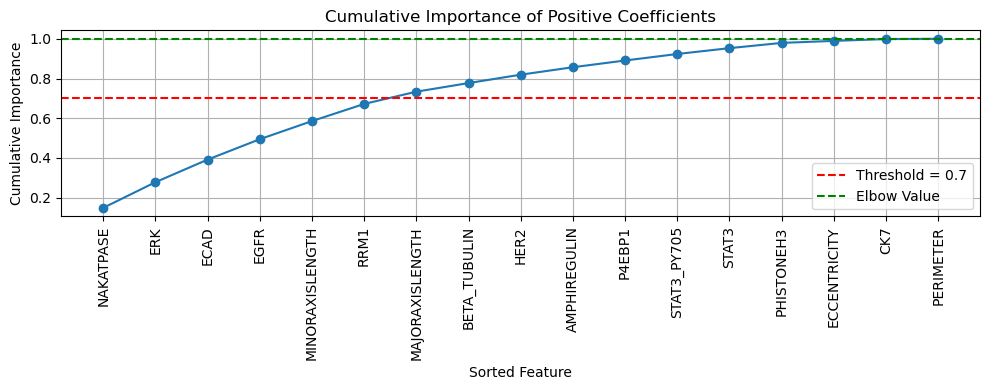

['NAKATPASE', 'ERK', 'ECAD', 'EGFR', 'MINORAXISLENGTH', 'RRM1', 'MAJORAXISLENGTH']

AIC analysis:
results already cached, pulling now...


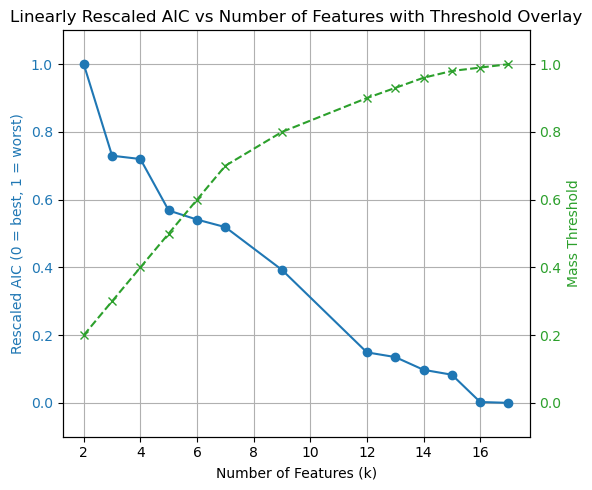

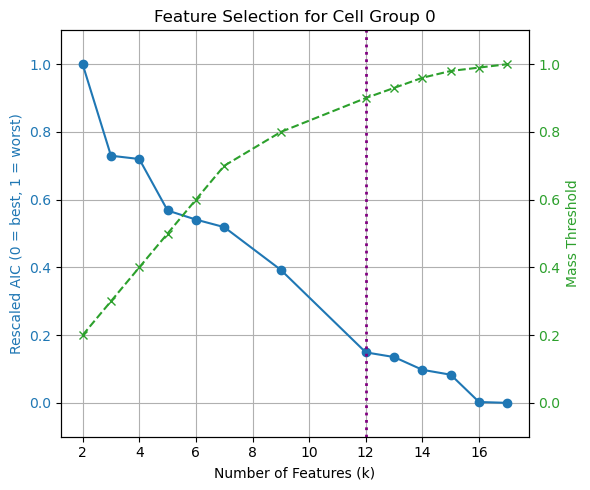

Automatically selected k: 12


In [52]:
run_full_aic_analysis(0, clf, all_feats, Xt, yt_multi)

### Concept 2

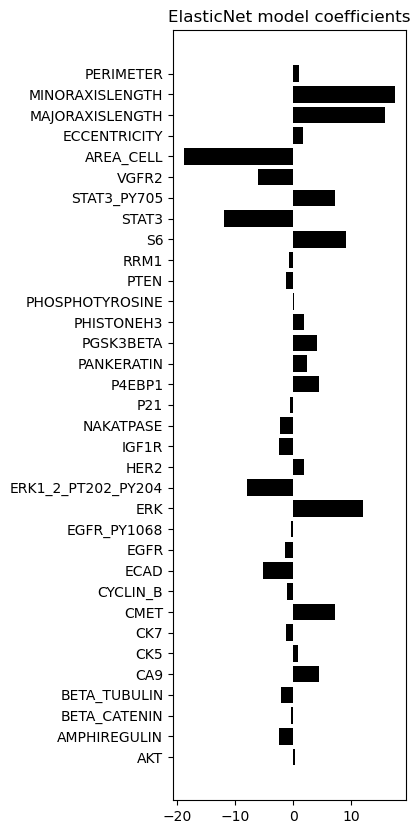


positive weights:
[('MINORAXISLENGTH', np.float64(17.621188191223432)), ('MAJORAXISLENGTH', np.float64(15.90319531239315)), ('ERK', np.float64(12.165112596192843)), ('S6', np.float64(9.11434265453015)), ('STAT3_PY705', np.float64(7.22877508436714))]
[(np.str_('MINORAXISLENGTH'), np.float64(17.621188191223432)), (np.str_('MAJORAXISLENGTH'), np.float64(15.90319531239315)), (np.str_('ERK'), np.float64(12.165112596192843)), (np.str_('S6'), np.float64(9.11434265453015)), (np.str_('STAT3_PY705'), np.float64(7.22877508436714)), (np.str_('CMET'), np.float64(7.166258145003224))]

visualizing positive weights:


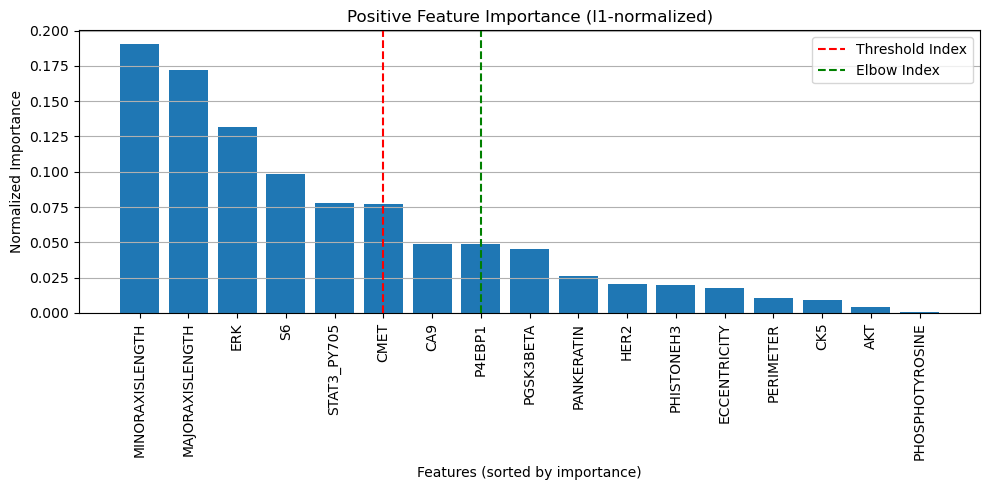

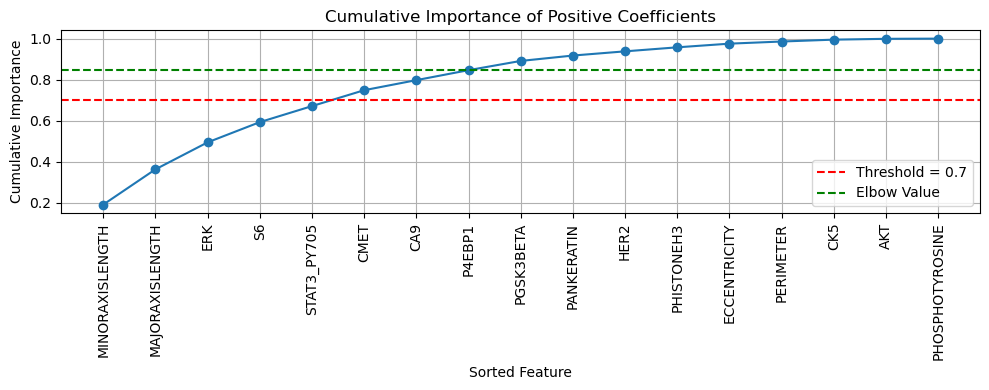

['MINORAXISLENGTH', 'MAJORAXISLENGTH', 'ERK', 'S6', 'STAT3_PY705', 'CMET']

AIC analysis:
results already cached, pulling now...


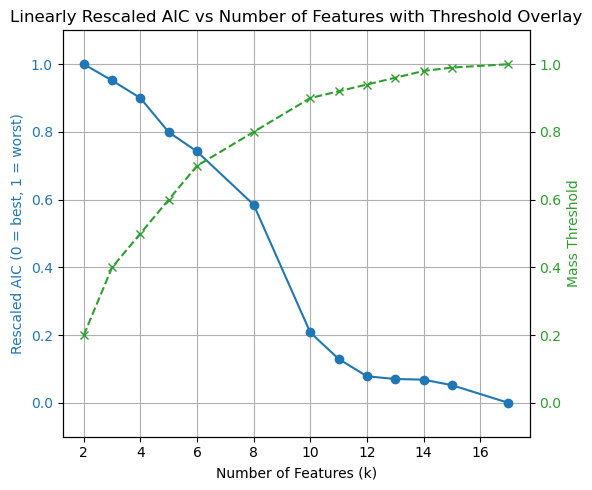

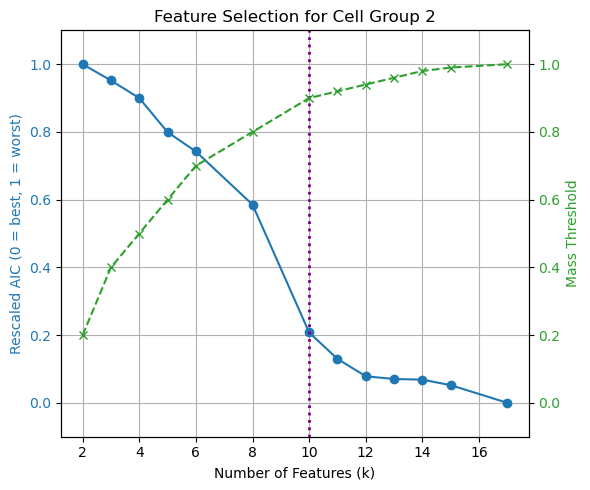

Automatically selected k: 10


In [53]:
run_full_aic_analysis(2, clf, all_feats, Xt, yt_multi)

### Concept 4

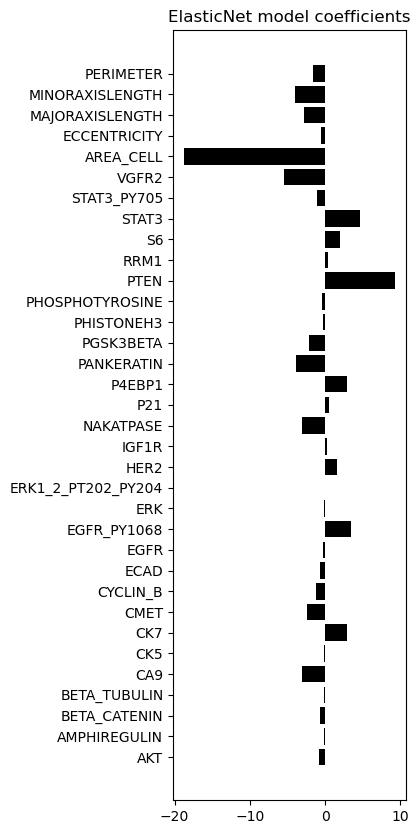


positive weights:
[('PTEN', np.float64(9.280332717467271)), ('STAT3', np.float64(4.619957840341633)), ('EGFR_PY1068', np.float64(3.3729046267752585)), ('CK7', np.float64(2.884037979226238)), ('P4EBP1', np.float64(2.8629207297835926))]
[(np.str_('PTEN'), np.float64(9.280332717467271)), (np.str_('STAT3'), np.float64(4.619957840341633)), (np.str_('EGFR_PY1068'), np.float64(3.3729046267752585)), (np.str_('CK7'), np.float64(2.884037979226238))]

visualizing positive weights:


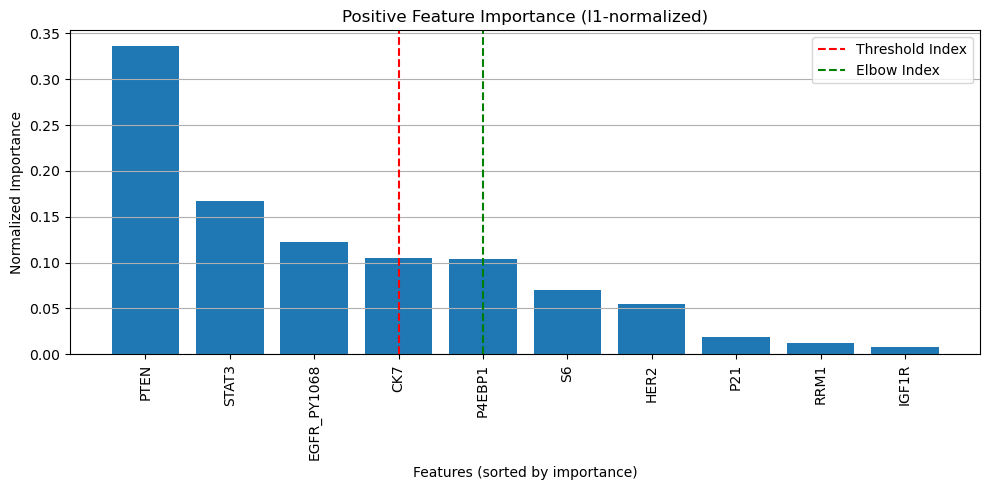

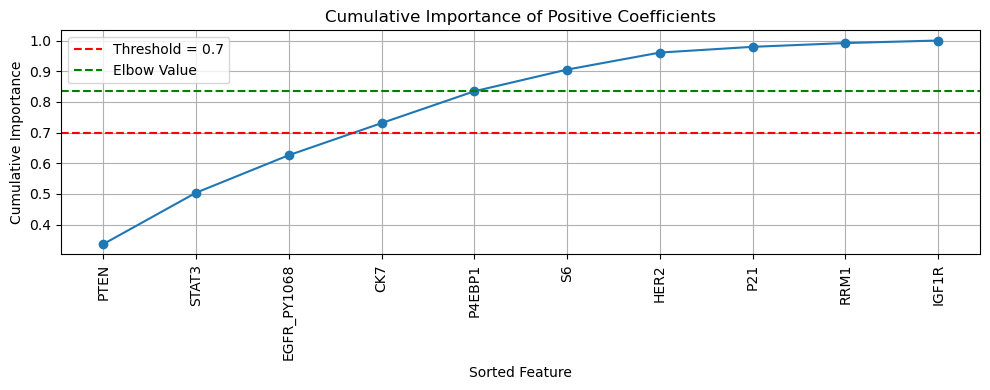

['PTEN', 'STAT3', 'EGFR_PY1068', 'CK7']

AIC analysis:
results already cached, pulling now...


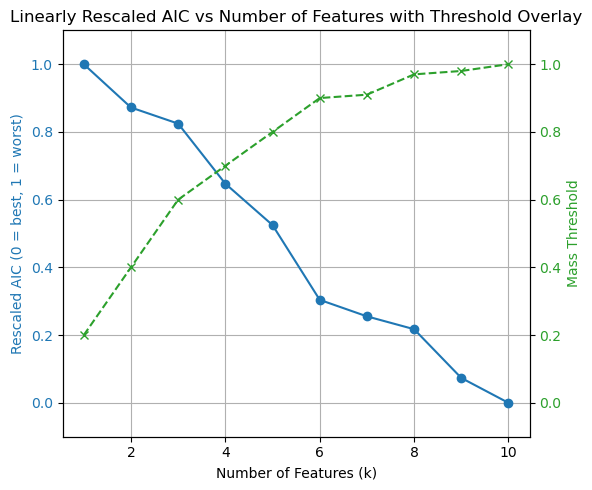

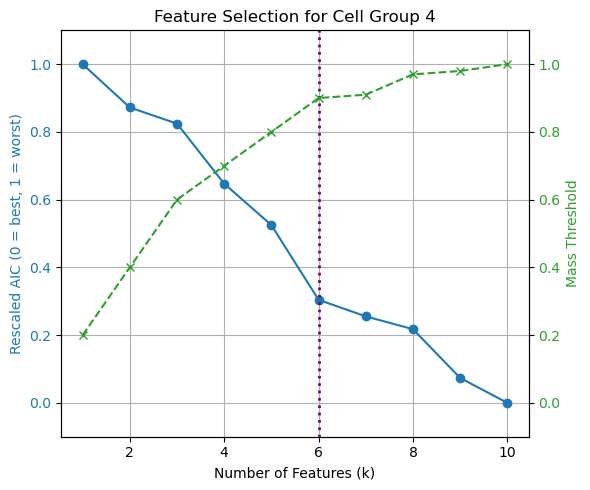

Automatically selected k: 6


In [54]:
run_full_aic_analysis(4, clf, all_feats, Xt, yt_multi)

In [55]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(3, 10))

# # concept 4
# # b = clf.estimators_[3].coef_[0] # importance weights
# b = clf.estimators_[5].coef_[0] # importance weights
# plt.barh(all_feats, b, color="k")

# # plt.barh(all_feats, b, color="k")
# plt.title("ElasticNet model coefficients")
# plt.show()

In [56]:
# scores = dict(zip(all_feats, b))
# list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

In [57]:
# sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
# top_positives_threshold_mass(sorted_scores, threshold=0.7)

In [58]:
# analyze_feature_importance_positives(b, all_feats, method='l1', threshold=0.70, plot=True)

In [60]:
# aic_results = compute_aic_by_threshold(clf.estimators_[5], Xt, yt_multi, all_feats)

In [59]:
# plot_aic_k_threshold(aic_results)
# plot_aic_threshold_k(aic_results)

### Concept 5

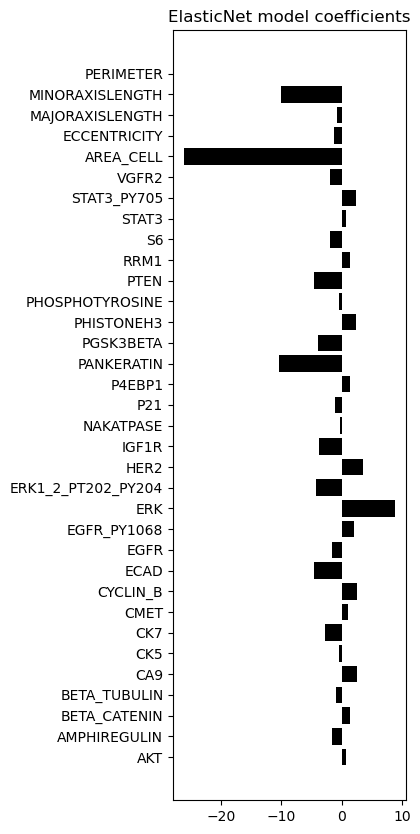


positive weights:
[('ERK', np.float64(8.860655058134768)), ('HER2', np.float64(3.5366337081573587)), ('CA9', np.float64(2.586429554239417)), ('CYCLIN_B', np.float64(2.5258923253502656)), ('STAT3_PY705', np.float64(2.388823657413002))]
[(np.str_('ERK'), np.float64(8.860655058134768)), (np.str_('HER2'), np.float64(3.5366337081573587)), (np.str_('CA9'), np.float64(2.586429554239417)), (np.str_('CYCLIN_B'), np.float64(2.5258923253502656)), (np.str_('STAT3_PY705'), np.float64(2.388823657413002)), (np.str_('PHISTONEH3'), np.float64(2.3705295888194455))]

visualizing positive weights:


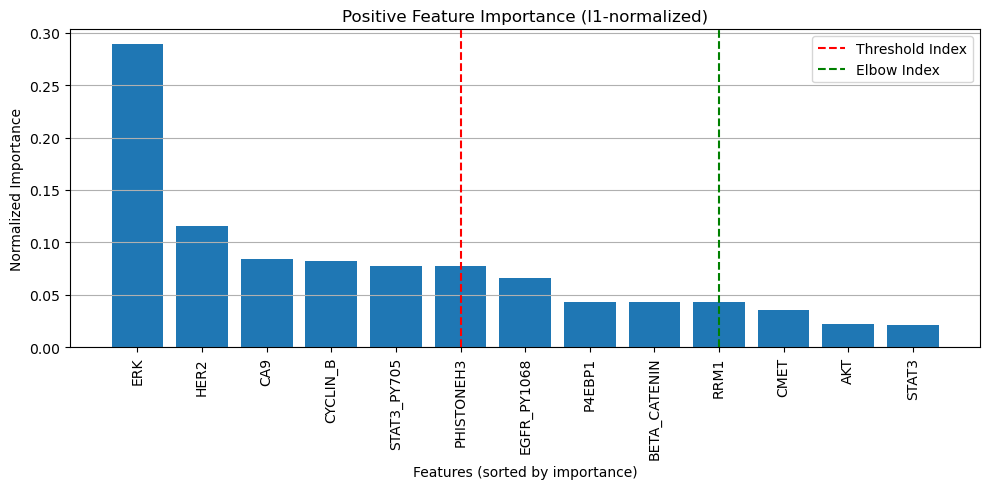

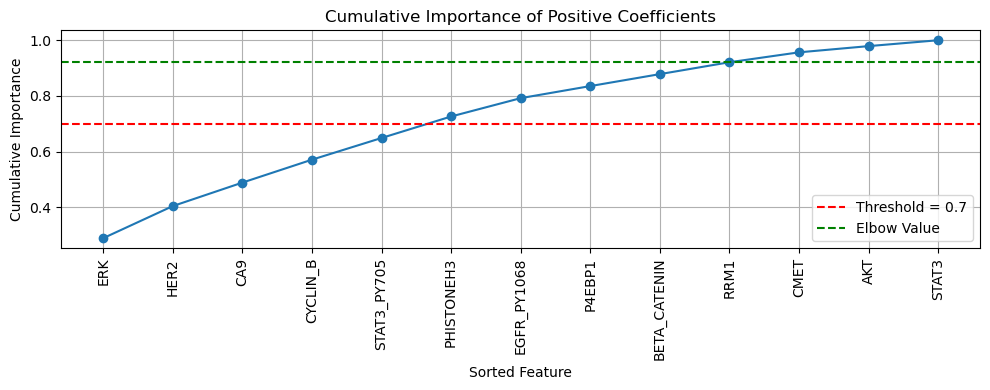

['ERK', 'HER2', 'CA9', 'CYCLIN_B', 'STAT3_PY705', 'PHISTONEH3']

AIC analysis:
results already cached, pulling now...


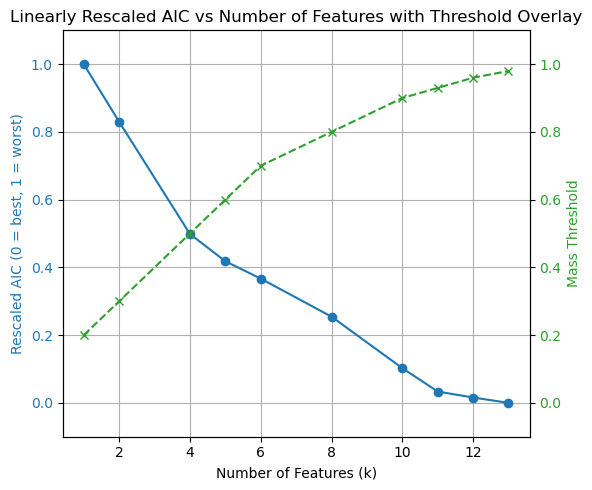

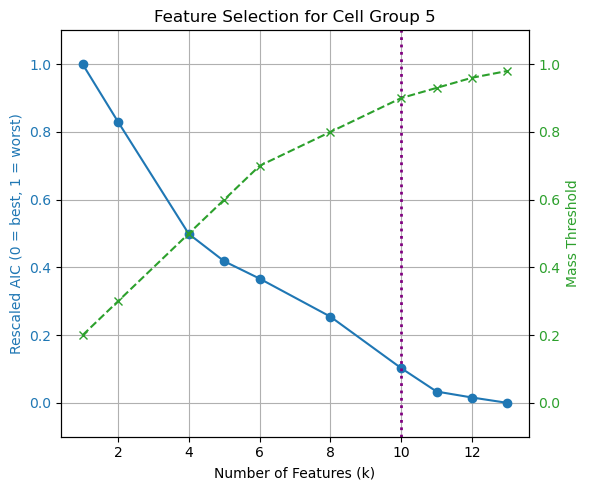

Automatically selected k: 10


In [61]:
run_full_aic_analysis(5, clf, all_feats, Xt, yt_multi)

### Concept 6

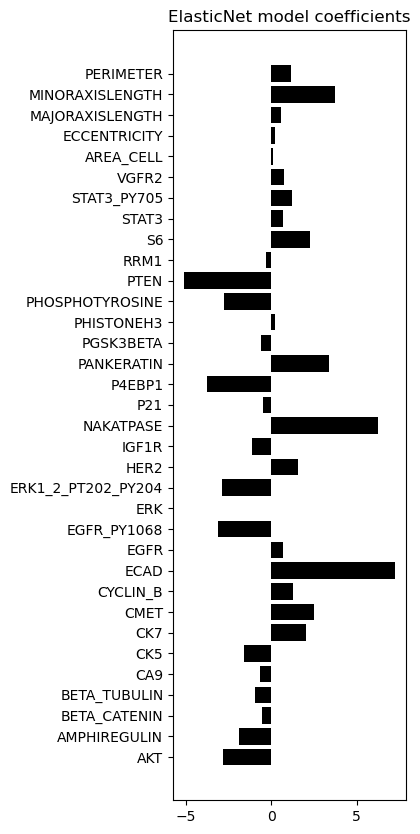


positive weights:
[('ECAD', np.float64(7.250364731334376)), ('NAKATPASE', np.float64(6.270181240844092)), ('MINORAXISLENGTH', np.float64(3.7609728088256147)), ('PANKERATIN', np.float64(3.3648529880856346)), ('CMET', np.float64(2.5023660150823637))]
[(np.str_('ECAD'), np.float64(7.250364731334376)), (np.str_('NAKATPASE'), np.float64(6.270181240844092)), (np.str_('MINORAXISLENGTH'), np.float64(3.7609728088256147)), (np.str_('PANKERATIN'), np.float64(3.3648529880856346)), (np.str_('CMET'), np.float64(2.5023660150823637)), (np.str_('S6'), np.float64(2.2553532464076045))]

visualizing positive weights:


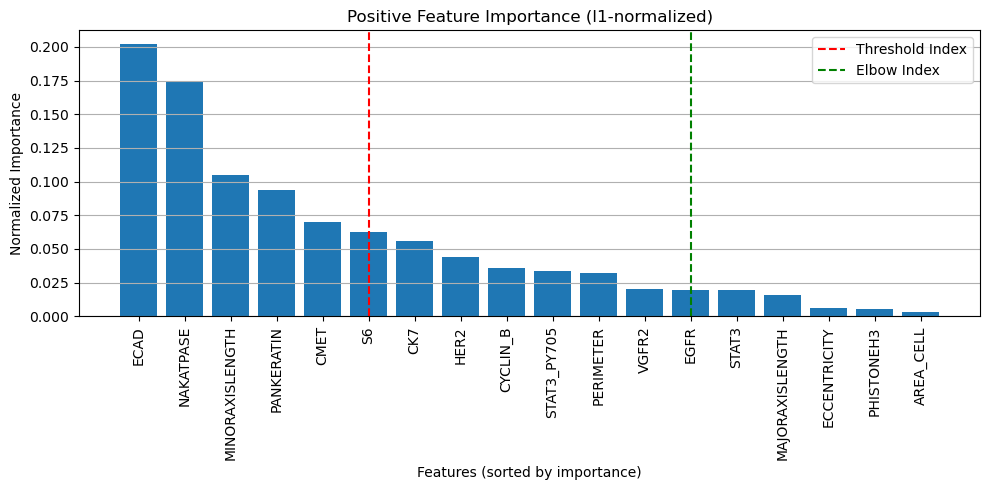

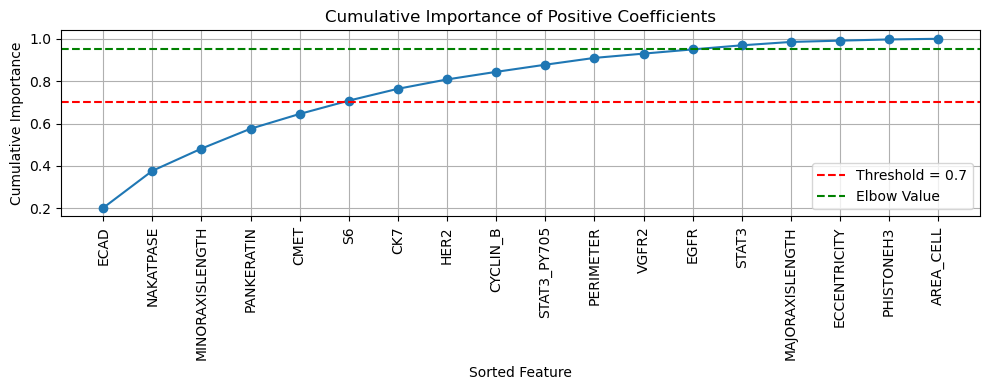

['ECAD', 'NAKATPASE', 'MINORAXISLENGTH', 'PANKERATIN', 'CMET', 'S6']

AIC analysis:
results missing, rerunning now...


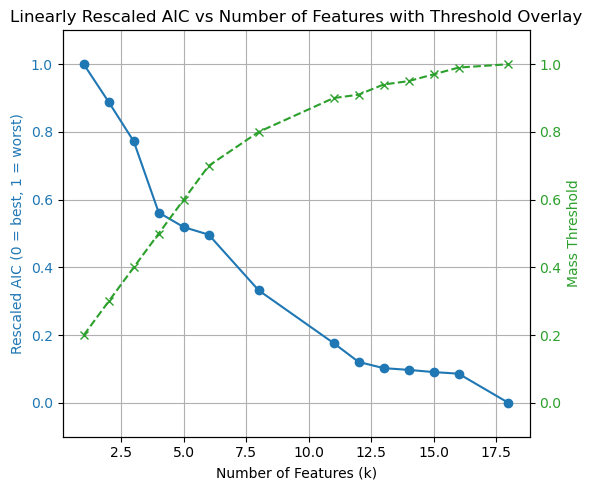

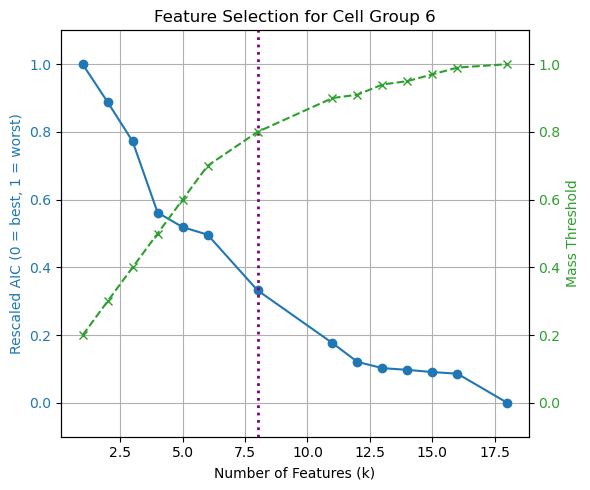

Automatically selected k: 8


In [64]:
run_full_aic_analysis(6, clf, all_feats, Xt, yt_multi)

### Concept 7

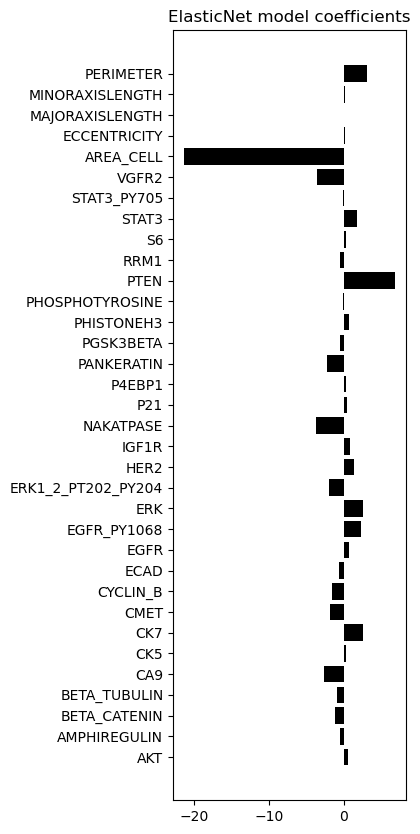


positive weights:
[('PTEN', np.float64(6.829910183918072)), ('PERIMETER', np.float64(3.052496750730959)), ('CK7', np.float64(2.5836317333016487)), ('ERK', np.float64(2.557861566276738)), ('EGFR_PY1068', np.float64(2.313028816466847))]
[(np.str_('PTEN'), np.float64(6.829910183918072)), (np.str_('PERIMETER'), np.float64(3.052496750730959)), (np.str_('CK7'), np.float64(2.5836317333016487)), (np.str_('ERK'), np.float64(2.557861566276738)), (np.str_('EGFR_PY1068'), np.float64(2.313028816466847))]

visualizing positive weights:


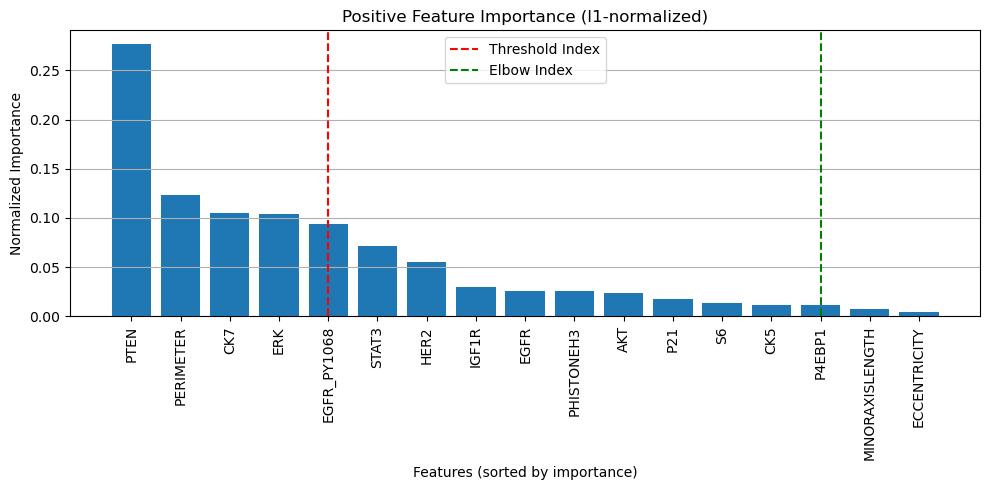

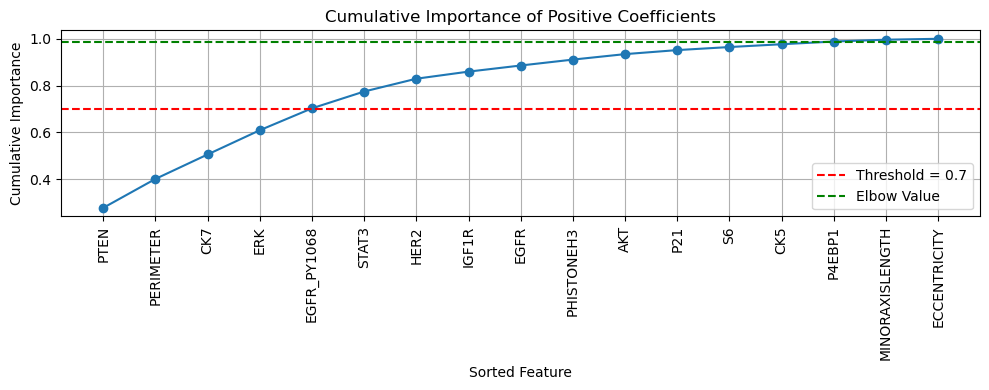

['PTEN', 'PERIMETER', 'CK7', 'ERK', 'EGFR_PY1068']

AIC analysis:
results missing, rerunning now...


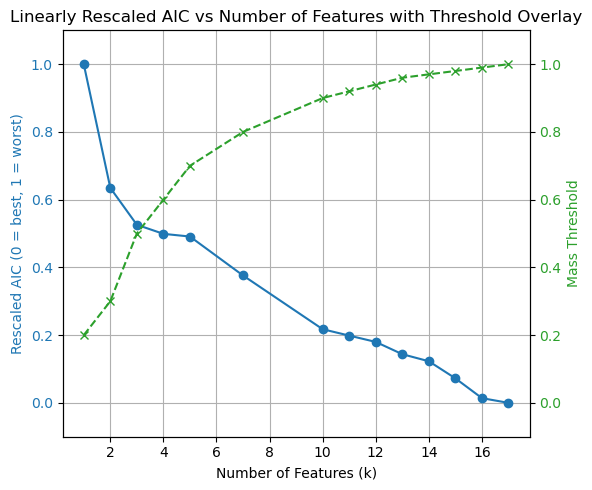

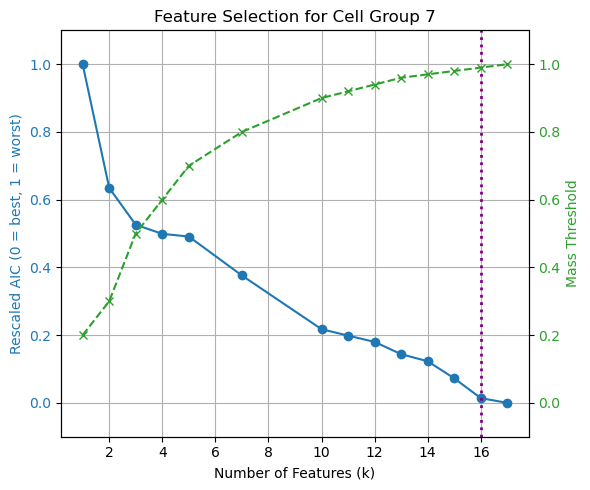

Automatically selected k: 16


In [65]:
run_full_aic_analysis(7, clf, all_feats, Xt, yt_multi)

### Concept 8 -- highly class-0

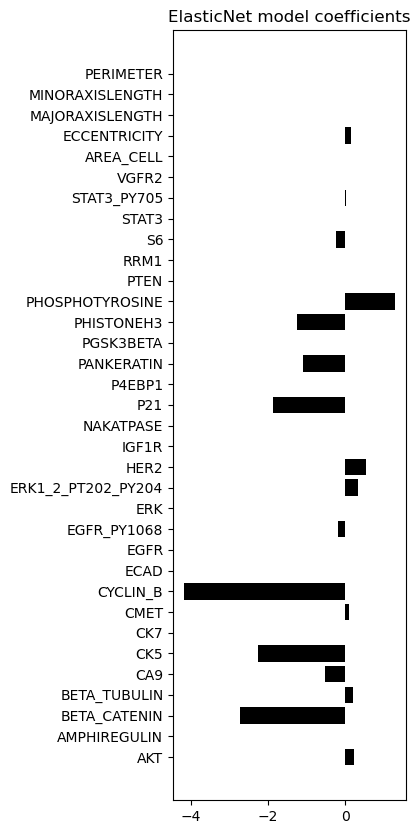


positive weights:
[('PHOSPHOTYROSINE', np.float64(1.2916646488002486)), ('HER2', np.float64(0.5455672345886288)), ('ERK1_2_PT202_PY204', np.float64(0.339015747497088)), ('AKT', np.float64(0.2154934096727448)), ('BETA_TUBULIN', np.float64(0.20121890210235077))]
[(np.str_('PHOSPHOTYROSINE'), np.float64(1.2916646488002486)), (np.str_('HER2'), np.float64(0.5455672345886288)), (np.str_('ERK1_2_PT202_PY204'), np.float64(0.339015747497088))]

visualizing positive weights:


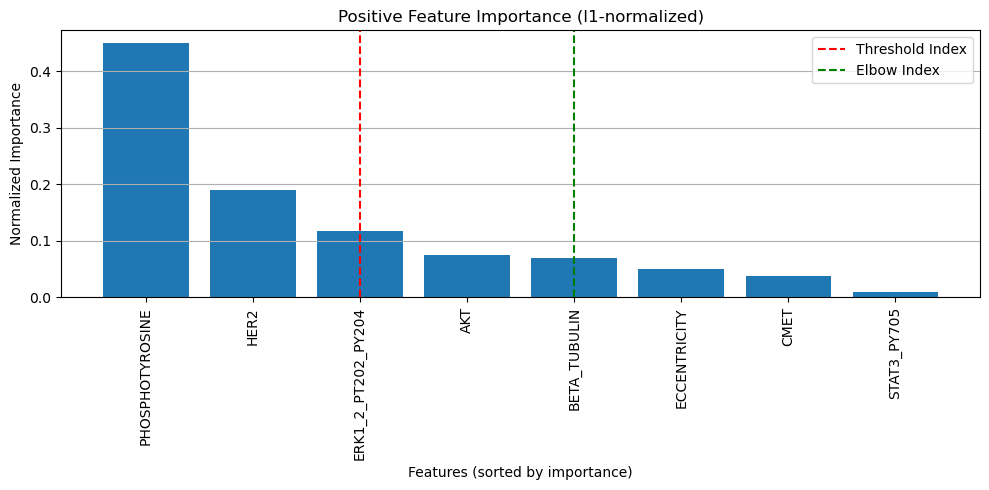

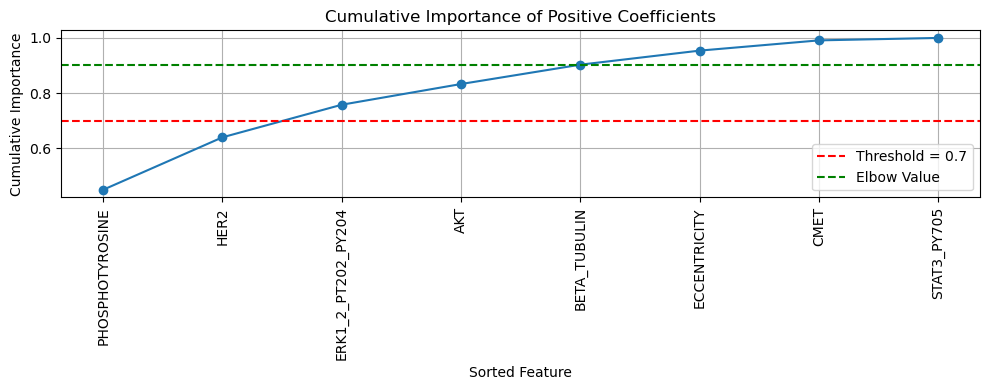

['PHOSPHOTYROSINE', 'HER2', 'ERK1_2_PT202_PY204']

AIC analysis:
results missing, rerunning now...


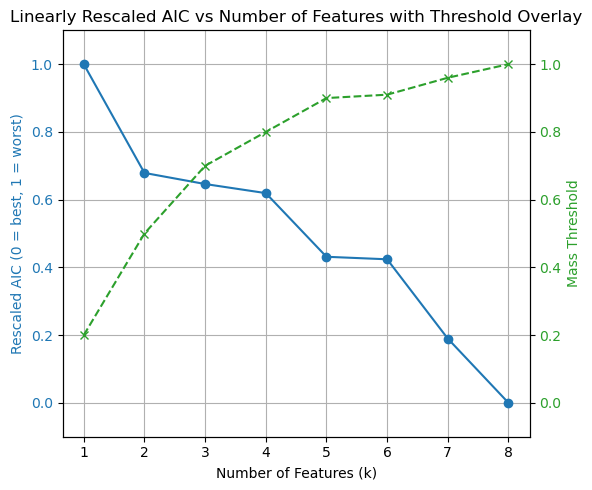

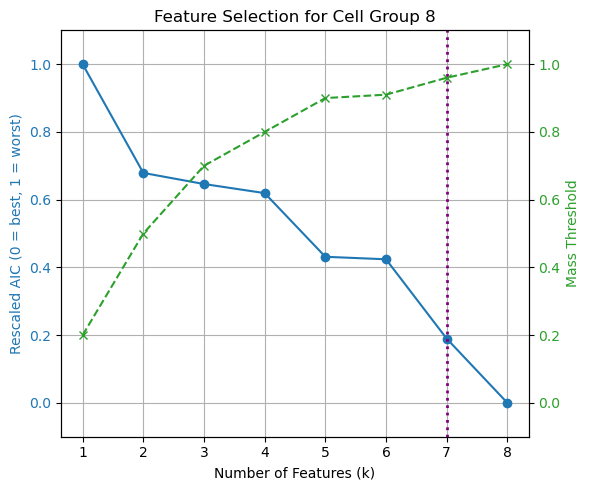

Automatically selected k: 7


In [63]:
run_full_aic_analysis(8, clf, all_feats, Xt, yt_multi)

### Nonsalient

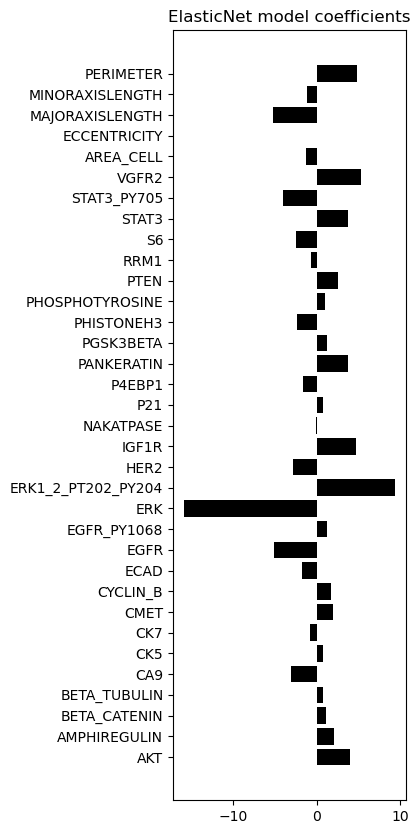


positive weights:
[('ERK1_2_PT202_PY204', np.float64(9.397342212573157)), ('VGFR2', np.float64(5.343947063917288)), ('PERIMETER', np.float64(4.899181437624918)), ('IGF1R', np.float64(4.713357684093525)), ('AKT', np.float64(4.04281132686891))]
[(np.str_('ERK1_2_PT202_PY204'), np.float64(9.397342212573157)), (np.str_('VGFR2'), np.float64(5.343947063917288)), (np.str_('PERIMETER'), np.float64(4.899181437624918)), (np.str_('IGF1R'), np.float64(4.713357684093525)), (np.str_('AKT'), np.float64(4.04281132686891)), (np.str_('STAT3'), np.float64(3.8191287514814403)), (np.str_('PANKERATIN'), np.float64(3.714426857470552))]

visualizing positive weights:


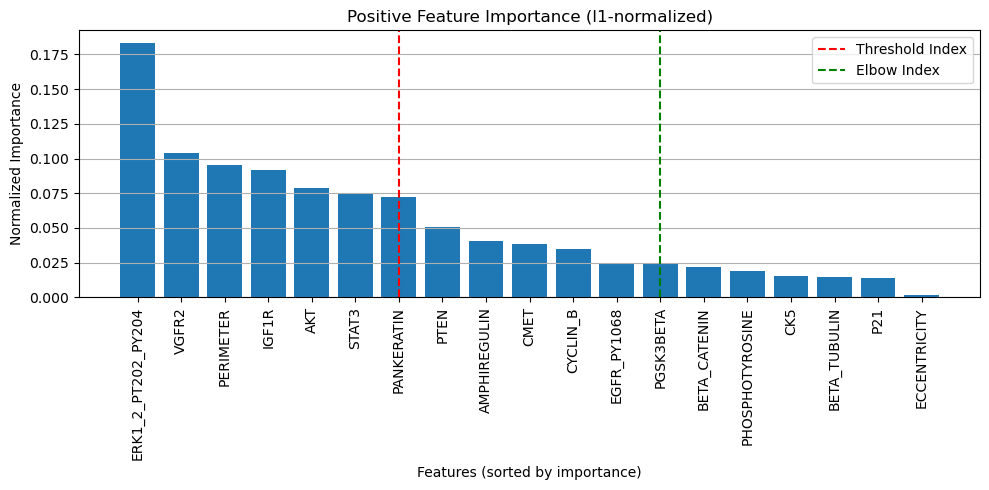

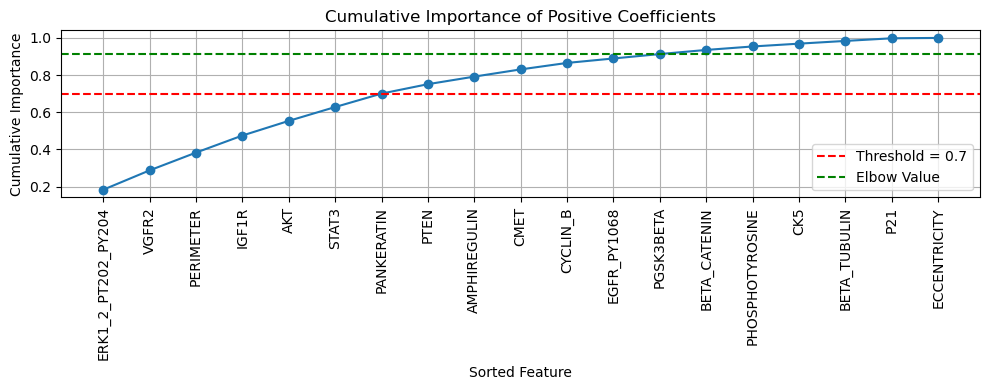

['ERK1_2_PT202_PY204', 'VGFR2', 'PERIMETER', 'IGF1R', 'AKT', 'STAT3', 'PANKERATIN']

AIC analysis:
results already cached, pulling now...


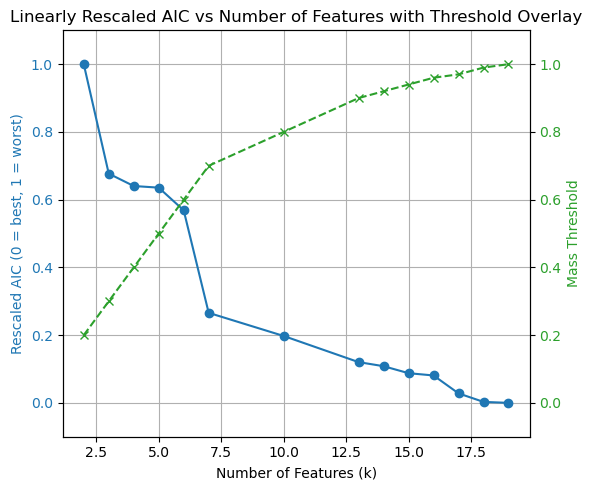

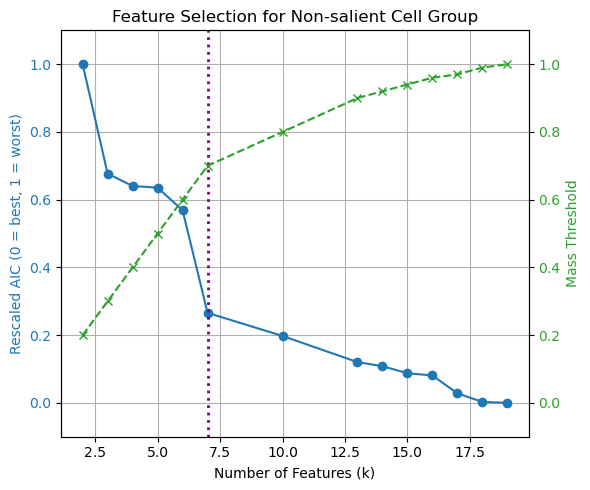

Automatically selected k: 7


In [66]:
run_full_aic_analysis(-1, clf, all_feats, Xt, yt_multi)

### Compare all

In [172]:

def plot_multiple_cumulative_importances(coef_list, names, threshold=0.7):
    """
    Plots cumulative importance curves for multiple sets of logistic regression coefficients.
    Only positive coefficients are considered. All curves are scaled from 0 to 1.

    Parameters:
        coef_list: List of 1D numpy arrays of coefficients (length = number of models).
        threshold: Float for horizontal threshold line (e.g., 0.8).
    """
    plt.figure(figsize=(6, 6))
    for i, coefs in enumerate(coef_list):
        pos_coefs = coefs[coefs > 0]
        if len(pos_coefs) == 0:
            continue
        importance = pos_coefs / np.sum(pos_coefs)
        sorted_importance = np.sort(importance)[::-1]
        cumulative = np.cumsum(sorted_importance)
        scaled_cumulative = cumulative / cumulative[-1]  # scale to [0, 1]
        plt.plot(range(len(scaled_cumulative)), scaled_cumulative, label=names[i], marker="o")

    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
    plt.title('Cumulative Importance of Positive Coefficients (Scaled)')
    plt.xlabel('Feature Index (sorted by importance)')
    plt.ylabel('Cumulative Importance (scaled)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


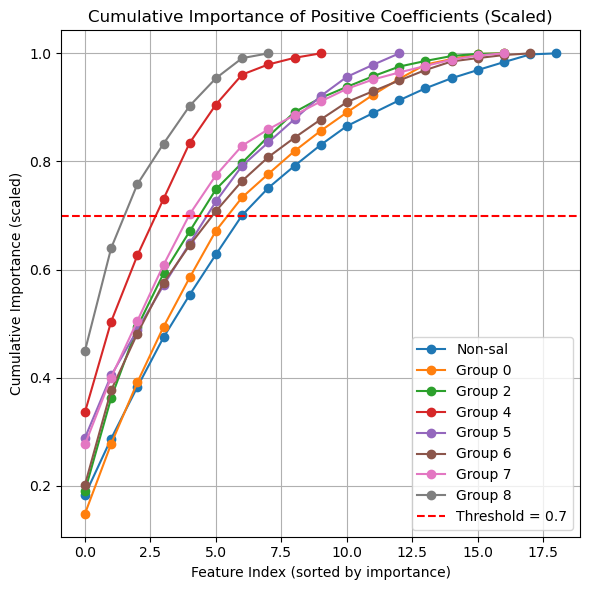

In [173]:
coef_list = [clf.estimators_[i].coef_[0] for i in [0,1,3,5,6,7,8,9]]
names = ["Non-sal", "Group 0", "Group 2", "Group 4", "Group 5", "Group 6", "Group 7", "Group 8"]
plot_multiple_cumulative_importances(coef_list, names, threshold=0.7)

## Try XGBoost

In [33]:
import xgboost as xgb
xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [34]:
# X, Xt, y, yt = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42) 

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
# Xt = scaler.transform(Xt)

In [35]:
xg.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [36]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
y_pred = xg.predict(X)
score = accuracy_score(y, y_pred)
print(score)

0.9695552397814573


previous: 0.970250533818646
, 0.9707634556493591


In [37]:
y_pred = xg.predict(Xt)
score = accuracy_score(yt, y_pred)

print(xg.score(Xt, yt))
print(score)

0.9600911854103343
0.9600911854103343


previous: 0.9596808510638298
, 0.9611702127659575

In [38]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yt, xg.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

np.float64(0.9924553436968719)

previous: 0.9922813384514227, 0.9925512772569732


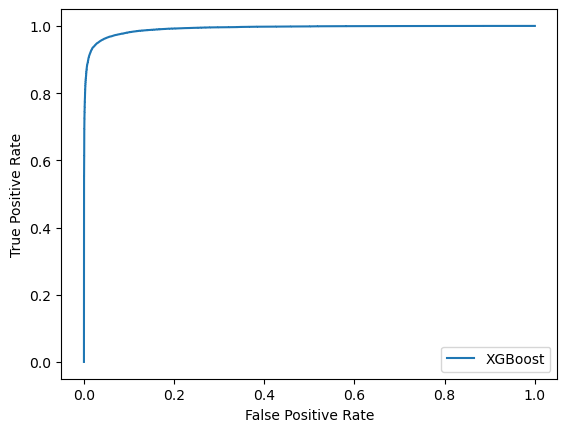

In [50]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [39]:
metrics.balanced_accuracy_score(y, xg.predict(X))

np.float64(0.9695464169024564)

previous: 0.9702522628124022, 0.9707721996931498

In [40]:
xg_scrambled = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xg_scrambled.fit(X, y_scramble)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# xgb.plot_importance(xg)

In [53]:
# all_feats[18], all_feats[6], all_feats[8], all_feats[24]

In [54]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(2, 10))


# # b = xg.feature_importances_
# b = xg.get_booster().get_score(importance_type="gain").values()
# # b = xg.get_booster().get_score(importance_type="weight").values()


# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, b, color="gray")
# plt.axvline(x=260, color='red', linewidth=1, linestyle=':')


# # plt.barh(all_feats, b, color="k")
# plt.title("XGBoost\nfeature gain")
# plt.show()

In [55]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(2, 10))


# # b = xg.feature_importances_
# b = xg.get_booster().get_score(importance_type="weight").values()
# # b = xg.get_booster().get_score(importance_type="weight").values()


# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, b, color="gray")
# plt.axvline(x=238, color='red', linewidth=1, linestyle=':')


# # plt.barh(all_feats, b, color="k")
# plt.title("XGBoost\nfeature frequency")
# plt.show()

old code below: not using the gbc package

In [100]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(X, y)

In [101]:
# print(gbc.score(X, y))
# print(gbc.score(Xt, yt))

# print(gbc.feature_importances_)


In [102]:
# fpr, tpr, thresholds = metrics.roc_curve(yt, gbc.predict_proba(Xt)[:,1])
# metrics.auc(fpr, tpr)

In [103]:
# # plot the roc curve for the model
# plt.figure()
# plt.plot(fpr, tpr, label='XGBoost')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# plt.show()

In [104]:
# plt.barh(all_feats, gbc.feature_importances_)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(3, 10))


# b = gbc.feature_importances_
# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, b, color="k")


# # plt.barh(all_feats, b, color="k")
# plt.title("XGBoost feature importance")
# plt.show()

In [105]:
# features = [0, 1, (0, 1)]
# PartialDependenceDisplay.from_estimator(clf, X, features)


## Try MLP

In [42]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=1, max_iter=10000)

In [43]:
nn.fit(X, y)

MLPClassifier(max_iter=10000, random_state=1)

In [45]:
utils.serialize(nn, "/oak/stanford/groups/paragm/gautam/prospection/K2/notebooks/spatial-bio/mlp_model_8-6.obj")
# nn = utils.deserialize("/oak/stanford/groups/paragm/gautam/prospection/K2/notebooks/spatial-bio/mlp_model_8-6.obj")

In [46]:
nn.score(Xt, yt)

0.9489817629179331

previous: 0.954741641337386
, 0.954726443768997

In [47]:
nn.score(X, y)

0.9531075464099271

previous: 0.9592360124317054, 0.959198018222023


In [48]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yt, nn.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

np.float64(0.9880094350863005)

previous: 0.9887576776654964, 0.9884979177385215

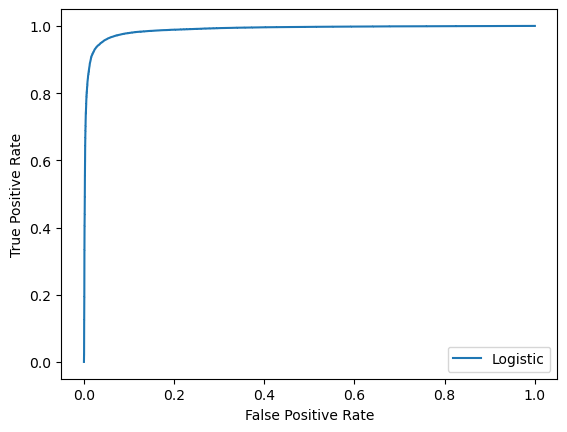

In [61]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [62]:
metrics.balanced_accuracy_score(yt, nn.predict(Xt))

np.float64(0.9547490592974506)

previous: 0.9546956366185525

In [49]:
nn_scrambled = MLPClassifier(random_state=1, max_iter=10000) 
nn_scrambled.fit(X, y_scramble)

MLPClassifier(max_iter=10000, random_state=1)

In [240]:
# import shap
# explainer = shap.KernelExplainer(nn.predict, data=shap.sample(X,100), feature_names=all_feats)
# shap_values = explainer(X[:1000,:])

In [241]:
# shap_values.shape

In [242]:
# shap.plots.bar(shap_values)

In [243]:
# # plt.barh(all_feats, np.abs(shap_values.values).mean(0))

# import matplotlib.pyplot as plt
# plt.figure(figsize=(2, 10))


# b = np.abs(shap_values.values).mean(0)
# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, np.abs(shap_values.values).mean(0), color="gray")
# plt.axvline(x=0.036427, color='red', linewidth=1, linestyle=':')
# # plt.barh(all_feats, b, color="k")
# plt.title("MLP\nShapley values")
# plt.show()

In [244]:
# shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")


# Plotting all performances

ElasticNet
Training score: 0.7135388566782422 0.7135388566782422
Subset score: 0.7159726443768997 0.7159726443768997
Training auc: 0.7831362125797225
Subset auc: 0.781486162654537

XGBoost
Training score: 0.9695552397814573 0.9695552397814573
Subset score: 0.9600911854103343 0.9600911854103343
Training auc: 0.9924553436968719
Subset auc: 0.9954911753546818

MLP
Training score: 0.9531075464099271 0.9531075464099271
Subset score: 0.9489817629179331 0.9489817629179331
Training auc: 0.9880094350863005
Subset auc: 0.9913404597985065

ElasticNet (rand)
Training score: 0.4990463453369706 0.4990463453369706
Subset score: 0.4960790273556231 0.4960790273556231
Training auc: 0.4882772766178179
Subset auc: 0.48887275616026

XGBoost (rand)
Training score: 0.4993047059628113 0.4993047059628113
Subset score: 0.4957142857142857 0.4957142857142857
Training auc: 0.49418477987660825
Subset auc: 0.49695516520375976

MLP (rand)
Training score: 0.5050456310458287 0.5050456310458287
Subset score: 0.502264437

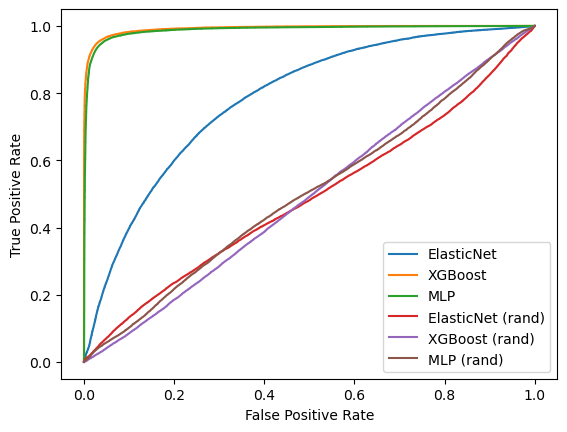

In [51]:
import matplotlib.pyplot as plt
plt.figure()
labs = ["ElasticNet", "XGBoost", "MLP", "ElasticNet (rand)", "XGBoost (rand)", "MLP (rand)"]
for i, classifier in enumerate([clf_all, xg, nn, clf_all_scrambled, xg_scrambled, nn_scrambled]):
    y_pred = classifier.predict(X)
    y_prob = classifier.predict_proba(X)[:,1]
    y_predt = classifier.predict(Xt)
    y_probt = classifier.predict_proba(Xt)[:,1]
    
    score = accuracy_score(y, y_pred)
    scoret = accuracy_score(yt, y_predt)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    auc = metrics.auc(fpr, tpr)
    
    fpr, tpr, thresholds = metrics.roc_curve(yt, y_probt)
    auct = metrics.auc(fpr, tpr)
    
    print(labs[i])
    print("Training score:", classifier.score(X, y), score)
    print("Subset score:", classifier.score(Xt, yt), scoret)
    print("Training auc:", auct)
    print("Subset auc:", auc)
    print()
    plt.plot(fpr, tpr, label=labs[i])


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
# show the legend
plt.legend()
plt.show()

ElasticNet
Training acc: 0.7135388566782422
Subset acc: 0.7159726443768997
Training AUC: 0.781486162654537
Subset AUC: 0.7831362125797225

XGBoost
Training acc: 0.9695552397814573
Subset acc: 0.9600911854103343
Training AUC: 0.9954911753546818
Subset AUC: 0.9924553436968719

MLP
Training acc: 0.9531075464099271
Subset acc: 0.9489817629179331
Training AUC: 0.9913404597985065
Subset AUC: 0.9880094350863005

ElasticNet (rand)
Training acc: 0.4990463453369706
Subset acc: 0.4960790273556231
Training AUC: 0.48887275616026
Subset AUC: 0.4882772766178179

XGBoost (rand)
Training acc: 0.4993047059628113
Subset acc: 0.4957142857142857
Training AUC: 0.49695516520375976
Subset AUC: 0.49418477987660825

MLP (rand)
Training acc: 0.5050456310458287
Subset acc: 0.5022644376899696
Training AUC: 0.500201945106353
Subset AUC: 0.5032929140480498



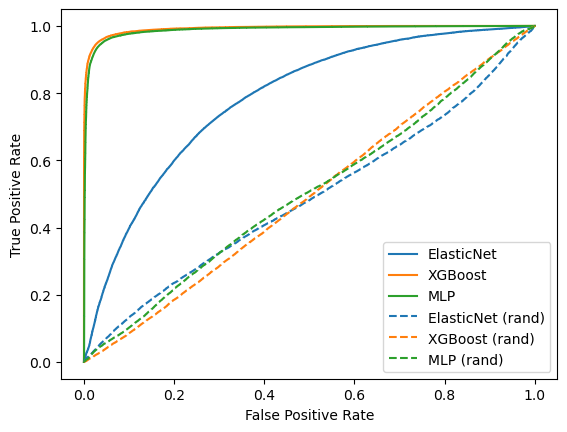

In [52]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score

base_labels = ["ElasticNet", "XGBoost", "MLP"]
scr_labels  = [f"{b} (rand)" for b in base_labels]
classifiers = [clf_all, xg, nn, clf_all_scrambled, xg_scrambled, nn_scrambled]

plt.figure()

# grab the default color cycle (at least 3 colors guaranteed)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, clf in enumerate(classifiers):
    # predictions
    y_pred  = clf.predict(X)
    y_prob  = clf.predict_proba(X)[:, 1]
    y_predt = clf.predict(Xt)
    y_probt = clf.predict_proba(Xt)[:, 1]

    # metrics
    fpr_tr, tpr_tr, _ = metrics.roc_curve(y, y_prob)
    auc_tr = metrics.auc(fpr_tr, tpr_tr)

    fpr_te, tpr_te, _ = metrics.roc_curve(yt, y_probt)
    auc_te = metrics.auc(fpr_te, tpr_te)

    # logging
    name = base_labels[i] if i < 3 else scr_labels[i-3]
    print(name)
    print("Training acc:", accuracy_score(y, y_pred))
    print("Subset acc:",   accuracy_score(yt, y_predt))
    print("Training AUC:", auc_tr)
    print("Subset AUC:",   auc_te)
    print()

    # plot (test ROC); scrambled gets dashed but same color as its base
    if i < 3:
        plt.plot(fpr_te, tpr_te, label=base_labels[i], color=colors[i])
    else:
        j = i - 3
        plt.plot(fpr_te, tpr_te, label=scr_labels[j], color=colors[j], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [267]:
# serialize(clf_all, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/elasticnet_all.model")
# serialize(clf, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/elasticnet_ovr.model")
# serialize(nn, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/mlp.model")
# serialize(xg, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/xgb.model")

## Ranked importances

In [607]:
b = np.abs(shap_values.values).mean(0)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PANKERATIN', 0.06763494701111156),
 ('ERK', 0.06619372411547199),
 ('ERK1_2_PT202_PY204', 0.06268465046443415),
 ('PHOSPHOTYROSINE', 0.06140518376607049),
 ('CK7', 0.050512085371051875),
 ('P4EBP1', 0.04504883541661655),
 ('BETA_TUBULIN', 0.042672620112445304),
 ('EGFR_PY1068', 0.037442430756127215),
 ('P21', 0.037299226727438614),
 ('CK5', 0.036427114601221965),
 ('STAT3_PY705', 0.035540956545354704),
 ('PTEN', 0.03377113677918395),
 ('STAT3', 0.03357370341746178),
 ('CYCLIN_B', 0.03122854187987201),
 ('AMPHIREGULIN', 0.03078395883514001),
 ('CMET', 0.030775841585625963),
 ('RRM1', 0.029464411839870263),
 ('PGSK3BETA', 0.02838506081205425),
 ('HER2', 0.027328247137869636),
 ('AKT', 0.02703959601222384),
 ('ECAD', 0.026235758915382754),
 ('EGFR', 0.025544538729400008),
 ('IGF1R', 0.025306999399679262),
 ('BETA_CATENIN', 0.022768954094744807),
 ('NAKATPASE', 0.022703940859617956),
 ('PERIMETER', 0.021439343327611052),
 ('S6', 0.021214244656080357),
 ('CA9', 0.02067171774045274),
 ('P

In [600]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="gain").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PHISTONEH3', 415.1111755371094),
 ('ECAD', 317.6909484863281),
 ('STAT3_PY705', 307.5013122558594),
 ('IGF1R', 289.44036865234375),
 ('CYCLIN_B', 289.0143737792969),
 ('PHOSPHOTYROSINE', 266.583251953125),
 ('P4EBP1', 265.6700134277344),
 ('CK5', 264.4093322753906),
 ('PANKERATIN', 263.4822692871094),
 ('HER2', 262.51385498046875),
 ('EGFR_PY1068', 257.23822021484375),
 ('P21', 253.95278930664062),
 ('AREA_CELL', 250.98939514160156),
 ('CK7', 246.45985412597656),
 ('BETA_TUBULIN', 240.18124389648438),
 ('VGFR2', 234.13047790527344),
 ('RRM1', 224.6455841064453),
 ('PTEN', 218.48118591308594),
 ('CA9', 217.2509765625),
 ('ERK1_2_PT202_PY204', 212.64816284179688),
 ('PGSK3BETA', 210.91725158691406),
 ('STAT3', 186.13671875),
 ('BETA_CATENIN', 184.42208862304688),
 ('NAKATPASE', 172.2122344970703),
 ('CMET', 166.76290893554688),
 ('AMPHIREGULIN', 150.8935546875),
 ('AKT', 147.22865295410156),
 ('ERK', 136.35350036621094),
 ('EGFR', 134.2201385498047),
 ('S6', 77.5842056274414),
 ('MINO

In [601]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="weight").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)

[('P4EBP1', 414.0),
 ('CK7', 347.0),
 ('CYCLIN_B', 324.0),
 ('PHOSPHOTYROSINE', 308.0),
 ('BETA_TUBULIN', 307.0),
 ('RRM1', 296.0),
 ('HER2', 286.0),
 ('CK5', 272.0),
 ('PANKERATIN', 269.0),
 ('BETA_CATENIN', 245.0),
 ('P21', 233.0),
 ('PGSK3BETA', 221.0),
 ('PTEN', 197.0),
 ('ERK1_2_PT202_PY204', 182.0),
 ('VGFR2', 181.0),
 ('CMET', 180.0),
 ('IGF1R', 178.0),
 ('NAKATPASE', 173.0),
 ('ECAD', 163.0),
 ('AKT', 157.0),
 ('EGFR_PY1068', 155.0),
 ('CA9', 147.0),
 ('AMPHIREGULIN', 134.0),
 ('STAT3', 129.0),
 ('EGFR', 120.0),
 ('S6', 112.0),
 ('ERK', 110.0),
 ('STAT3_PY705', 90.0),
 ('PHISTONEH3', 73.0),
 ('MINORAXISLENGTH', 16.0),
 ('AREA_CELL', 15.0),
 ('MAJORAXISLENGTH', 8.0),
 ('PERIMETER', 5.0),
 ('ECCENTRICITY', 4.0)]